# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Modèle de classification par apprentissage supervisé

In [3]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Forêts Aléatoires

In [12]:
# définition du modèle
clf_rf = RandomForestClassifier()

In [13]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [14]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_rf = [{'n_estimators':[200], 'min_samples_leaf':[2], 'max_features':['log2'], 'class_weight':[{0:x, 1:1.0-x} for x in weights]}]

In [15]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring='f1_macro', n_jobs=-1, cv=3)

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': [{0: 0.0, 1: 1.0},
                                           {0: 0.018367346938775512,
                                            1: 0.9816326530612245},
                                           {0: 0.036734693877551024,
                                            1: 0.963265306122449},
                                           {0: 0.05510204081632654,
                                            1: 0.9448979591836735},
                                           {0: 0.07346938775510205,
                                            1: 0.926530612244898},
                                           {0: 0.09183673469387756,
                                            1: 0.9081632653061225},
                                           {0: 0.11020408163265...
                                           {0: 0.4408163265306123,
                                            1: 0.5591836734693877},
                                           {0: 0.4591836734693878,
                                            1: 0.5408163265306122},
                                           {0: 0.47755102040816333,
                                            1: 0.5224489795918367},
                                           {0: 0.49591836734693884,
                                            1: 0.5040816326530612},
                                           {0: 0.5142857142857143,
                                            1: 0.48571428571428565},
                                           {0: 0.5326530612244899,
                                            1: 0.46734693877551015}, ...],
                          'max_features': ['log2'], 'min_samples_leaf': [2],
                          'n_estimators': [200]}],
             scoring='f1_macro')

In [18]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas = gcv_rf.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.66).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# affichage du rapport de classification
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'class_weight': {0: 0.4408163265306123, 1: 0.5591836734693877}, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 200} 

Train Data Score: 0.978103275751699
Test Data Score: 0.7384425523145806

               precision    recall  f1-score   support

           0       0.90      0.90      0.90     21962
           1       0.65      0.64      0.64      6196

    accuracy                           0.84     28158
   macro avg       0.77      0.77      0.77     28158
weighted avg       0.84      0.84      0.84     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.90      0.64      0.90      0.76      0.59     21962
          1       0.65      0.64      0.90      0.64      0.76      0.56      6196

avg / total       0.84      0.84      0.70      0.84      0.76      0.58     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision et un rappel parfaitement équilibrés
- `un F1-score macro égal à 0.77`
- `une moyenne géométrique égale à 0.76`

### Interprétation du modèle

L'interprétabilité du modèle Random Forest se situe quelque part entre un "whitebox" (comme pour un arbre de decision) et un vrai "blackbox" (comme pour un réseau neuronal).

A partir du meilleur estimateur trouvé précédemment, nous analysons d'abord les résultats du modèle par l'importance des variables en considérant la diminution moyenne de l'impureté pour tous les arbres de notre forêt.

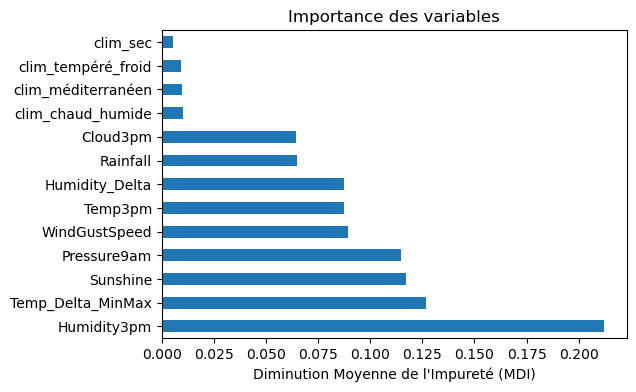

In [21]:
# affichage de l'importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
feature_imp = pd.Series(gcv_rf.best_estimator_.feature_importances_, index=data.columns)
feature_imp.nlargest(13).plot(kind='barh')
plt.title("Importance des variables")
plt.xlabel("Diminution Moyenne de l'Impureté (MDI)");

Comme nous l'avons vu pour les autres modèles, il apparaît clairement que la variable **"Humidity3pm"** est la plus importante dans ce modèle pour ce jeu de données.

Toutefois, deux problèmes subsistent avec les méthodes MDI pour déterminer l'importance des variables pour un jeu de données:

- la méthode est dépendante du modèle donc si le modèle est sujet au sur-apprentissage alors il peut y avoir un effet répercuté dans l'importance des variables également
- un biais de calcul peut survenir pour les variables numériques ou pour les variables présentant une grande cardinalité

Une autre technique d'inspection des modèles ne présente pas ces problèmes, il s'agit de la méthode de permutation importance qui se calcule sur le jeu de données de test. La fonction "permutation_importance" calcule l'importance des caractéristiques des estimateurs pour un jeu de données donné. Le paramètre *n_repeats* définit le nombre de fois qu'une entité est mélangée de manière aléatoire et renvoie un échantillon d'importance des caractéristiques. 

Cette méthode est légèrement plus coûteuse en temps de calcul que la méthode d'importance des variables.

In [22]:
# calcul de la permutation importance des estimateurs pour le jeu de données de test
result = permutation_importance(gcv_rf.best_estimator_, X_test_scaled, y_test, n_repeats=10, random_state=42)

In [23]:
# création de l'index relatif aux estimateurs triés par importance moyenne 
sorted_idx = np.flip(result.importances_mean.argsort())

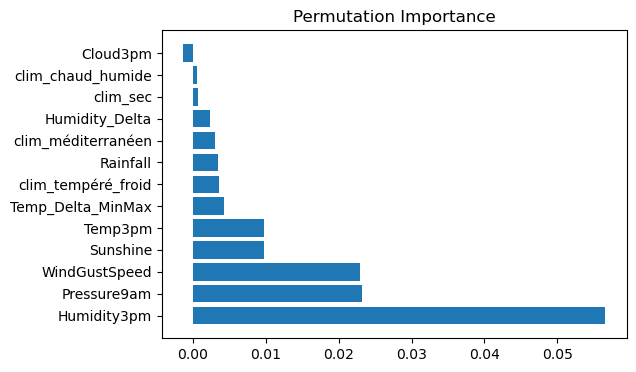

In [24]:
# affichage de la permutation importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

Avec cette méthode, on s'aperçoit que la variable "Pressure9am" est passée de la 4ème à la seconde position, devenant ainsi la variable la plus importante derrière "Humidity3pm". En revanche, la variable "Temp_Delta_MinMax" passe de la seconde à la 6ème position.